In [ ]:
import os
import numpy as np
import cv2

path = 'C:/Users/jumpr_000/Desktop/ransac_obstacle_detection/saved'
frames_dir = 'kinect_data/'
directory = os.fsencode(frames_dir)
frame_i = 0
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".npy"):
        file_path = frames_dir + filename
        print(file_path)
        img = np.uint8(np.load(file_path))
        cv2.imwrite(os.path.join(path ,filename[:-4] + '.png'), img)
cv2.destroyAllWindows()

C:\Users\jumpr_000\AppData\Roaming\Python\Python35\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\jumpr_000\AppData\Roaming\Python\Python35\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\jumpr_000\Desktop\ransac_obstacle_detection\obstacle_detection.py:110: RuntimeWarning: invalid value encountered in less
  if mean_val < HIGH_DISTANCE_BOUND: #kinect loses accuracy beyond 4.5m


New min:
num_planes 2 num_points 3 dist_thresh 0.1 loss 0.06298776358664959
New global min:
num_planes 2 num_points 3 dist_thresh 0.1 loss 0.06298776358664959
New min:
num_planes 2 num_points 5 dist_thresh 0.1 loss 0.20966628971319728
New min:
num_planes 6 num_points 5 dist_thresh 0.1 loss 0.20379749424997465
New min:
num_planes 10 num_points 5 dist_thresh 0.1 loss 0.17089615311885062
New min:
num_planes 16 num_points 5 dist_thresh 0.1 loss 0.16669768295488116
New min:
num_planes 28 num_points 5 dist_thresh 0.1 loss 0.16370602271222603
New min:
num_planes 30 num_points 5 dist_thresh 0.1 loss 0.12916694177945995
New min:
num_planes 36 num_points 5 dist_thresh 0.1 loss 0.0917510114392729
New min:
num_planes 42 num_points 5 dist_thresh 0.1 loss 0.07513739463986364
New min:
num_planes 52 num_points 5 dist_thresh 0.1 loss 0.05729044841712383
New global min:
num_planes 52 num_points 5 dist_thresh 0.1 loss 0.05729044841712383
New min:
num_planes 2 num_points 7 dist_thresh 0.1 loss 0.265820251

New min:
num_planes 42 num_points 43 dist_thresh 0.1 loss 0.0057220773108313085
New global min:
num_planes 42 num_points 43 dist_thresh 0.1 loss 0.0057220773108313085
New min:
num_planes 2 num_points 45 dist_thresh 0.1 loss 0.044571785712431776
New min:
num_planes 20 num_points 45 dist_thresh 0.1 loss 0.03759415904225971
New min:
num_planes 22 num_points 45 dist_thresh 0.1 loss 0.029071959977365926
New min:
num_planes 36 num_points 45 dist_thresh 0.1 loss 0.02107363510107287
New min:
num_planes 2 num_points 47 dist_thresh 0.1 loss 0.047018033325841486
New min:
num_planes 8 num_points 47 dist_thresh 0.1 loss 0.043336537378062985
New min:
num_planes 18 num_points 47 dist_thresh 0.1 loss 0.035310683547005735
New min:
num_planes 22 num_points 47 dist_thresh 0.1 loss 0.03213551245884203
New min:
num_planes 40 num_points 47 dist_thresh 0.1 loss 0.031028129297138336
New min:
num_planes 54 num_points 47 dist_thresh 0.1 loss 0.030573467686139222
New min:
num_planes 62 num_points 47 dist_thresh 

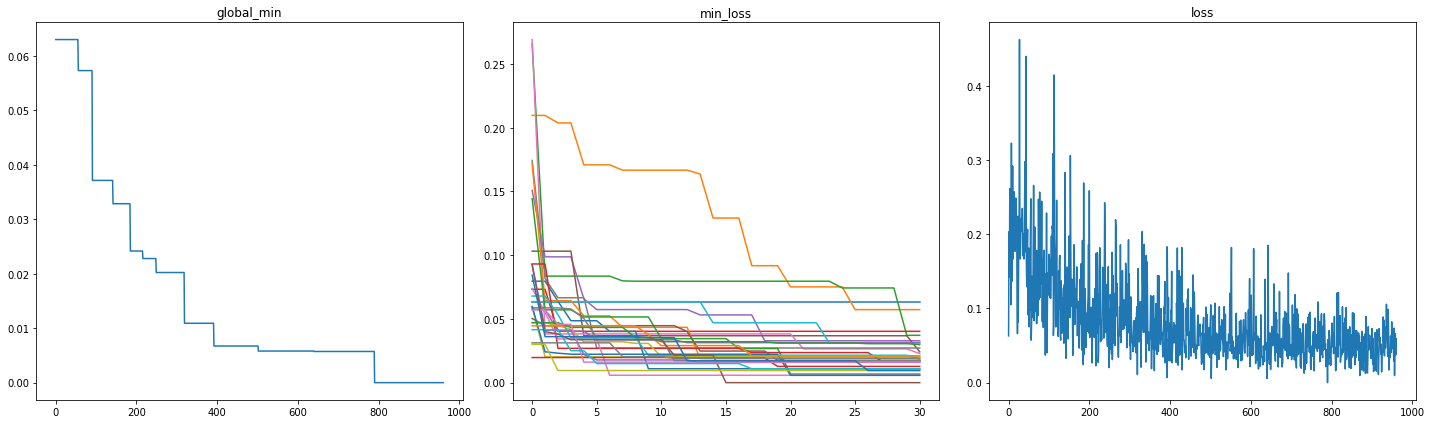

Optimal params: [32, 53, 0.1]


In [18]:
import os
import numpy as np
import cv2
import time
import math
import pandas as pd
from obstacle_detection import get_obstacles_with_plane
from depth_image_processing import *
import csv
import matplotlib.pyplot as plt
from scipy.optimize import minimize

path = 'kinect_data/'

num_planes = np.arange(2,64,2)#[2,5,8,16, 32]
num_points = np.arange(3,64,2)#[3,5,10,16, 32]
dist_thresh = [0.1]

def get_performance(x):
    planes = int(x[0])
    points = int(x[1])
    thresh = int(x[2])
    file_reader= open('test.csv', "rt", encoding='ascii')
    read = list(csv.reader(file_reader))
    
    accuracies = np.array([])
    
    skip = False
    
    for i in range(0,len(read)):
        if skip:
            skip = False
            continue
        row = read[i]
        img_path = path + row[0][:-4] + '.npy'
        if row[0] == 'img':
            continue
        frame = np.load(img_path)
        label = np.zeros(frame.shape, dtype = np.uint8)
        label = cv2.rectangle(label, (int(row[3]), int(row[5])), (int(row[4]), int(row[6])),(255,255,255), -1)
        if i < len(read) - 1:
            if row[0] == read[i + 1][0]:
                next_row = read[i + 1]
                label = cv2.rectangle(label, (int(next_row[3]), int(next_row[5])), (int(next_row[4]), int(next_row[6])),(255,255,255), -1)
                skip = True
        
        
        
        obstacles = get_obstacles_with_plane(frame, num_planes = planes, 
                                      num_points = points, 
                                      dist_thresh = thresh, 
                                      visualize = False)
        img = np.uint8(obstacles)
        intersect = cv2.bitwise_and(img, label) #find correct detetions
        accuracy = cv2.countNonZero(intersect) #count number of pixels correctly detected
        incorrect = cv2.countNonZero(cv2.subtract(img,label)) #count pixels outside of label
        truth = cv2.countNonZero(label)
        #print('Accuracy:', accuracy, 'Incorrect:', incorrect)
        accuracies = np.append(accuracies, incorrect / truth)
        key = cv2.waitKey(delay=1)
    return np.mean(accuracies)



#x0 = [10, 5, 0.1]
#res = minimize(get_performance, x0, method='nelder-mead',
#               options={'xtol': 1e-8, 'disp': True}) 

performance_graph = np.array([])
planes_graph = np.array([])
points_graph = np.array([])
thresh_graph = np.array([])
steps = np.array([])
step = 0
min_params = [10,5,.1]
loss_graph = np.array([])
global_min_graph = np.array([])
global_min = 1.0
min_loss = 1.0
epoch = 0
for thresh in dist_thresh:
    for point in num_points:
        current_loss = np.array([])
        min_loss = 1.0
        for plane in num_planes:
            steps = np.append(steps, step)
            points_graph = np.append(points_graph, point)
            planes_graph = np.append(planes_graph, plane)
            thresh_graph = np.append(thresh_graph, thresh)
            performance = get_performance([plane, point, thresh])
            if math.isnan(performance):
                performance = 1.0
            if performance < min_loss:
                print('New min:')
                print('num_planes',plane,'num_points', point,'dist_thresh', thresh,'loss', performance)
                min_loss = performance
            if performance < global_min:
                print('New global min:')
                print('num_planes',plane,'num_points', point,'dist_thresh', thresh,'loss', performance)
                global_min = performance
                
                min_params = [plane, point, thresh]
            global_min_graph = np.append(global_min_graph, global_min)
            current_loss = np.append(current_loss, min_loss)
            performance_graph = np.append(performance_graph, performance)
            step += 1
        if epoch == 0:
            loss_graph = np.append(loss_graph, current_loss)
        else:
            loss_graph = np.vstack((loss_graph, current_loss))
        epoch += 1

            
rows = 1
cols = 3
y_lists = {'loss':performance_graph,
           'min_loss':loss_graph,
           'global_min': global_min_graph}
graph_labels = list(y_lists.keys())
fig, axes = plt.subplots(rows, cols, figsize=(20,6))
fig.patch.set_facecolor('white')
for i in range(1,4):
    sub = plt.subplot(rows, cols, i)
    sub.set_title(graph_labels[i-1])
    if graph_labels[i-1] == 'min_loss':
        for graph in y_lists[graph_labels[i-1]]:
            print(graph)
            plt.plot(graph)
    else:
        plt.plot(y_lists[graph_labels[i-1]])
plt.tight_layout()
plt.show()

print('Optimal params:',min_params)


In [ ]:
plt.plot(performance_graph)
plt.plot(planes_graph)
plt.plot(points_graph)
plt.plot(thresh_graph)
plt.show()